In [4]:
import numpy as numpy
import pandas as pd
import yfinance as yf
import random
import csv
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime

In [5]:
#Get list of s&p 500 companies 
file = open("s&p500-list.csv")
reader = csv.DictReader(file)
symbols = [row['Symbol'] for row in reader]
file.close()
print(symbols[:16])

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN']


In [6]:
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day) #5 years back

#Pick any companies from the list (showing a subset to speed up processing time)
stocks_list = ['ADI', 'AMD', 'NVDA', 'IBM', 'ON']

"""Note: can also take a random sample of n companies by running:
stocks_list = random.sample(symbols, n) 
"""
df = yf.download(stocks_list, start, end)

df.info()

[*********************100%%**********************]  5 of 5 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-01-14 to 2024-01-12
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, ADI)   1259 non-null   float64
 1   (Adj Close, AMD)   1259 non-null   float64
 2   (Adj Close, IBM)   1259 non-null   float64
 3   (Adj Close, NVDA)  1259 non-null   float64
 4   (Adj Close, ON)    1259 non-null   float64
 5   (Close, ADI)       1259 non-null   float64
 6   (Close, AMD)       1259 non-null   float64
 7   (Close, IBM)       1259 non-null   float64
 8   (Close, NVDA)      1259 non-null   float64
 9   (Close, ON)        1259 non-null   float64
 10  (High, ADI)        1259 non-null   float64
 11  (High, AMD)        1259 non-null   float64
 12  (High, IBM)        1259 non-null   float64
 13  (High, NVDA)       1259 non-null   float64
 14  (High, ON)         1259 non-null   float64
 15  (Low, ADI)         1259 non-null   float64
 16  (Low, 

In [11]:
df.describe() 

Adj Close                                                      \
               ADI          AMD          IBM         NVDA           ON   
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean    140.912977    78.901104   116.508343   180.547807    46.642780   
std      31.874635    33.070867    15.797240   127.350539    25.351164   
min      76.735901    19.250000    75.172760    32.644463     8.450000   
25%     108.031315    52.299999   104.372665    71.413795    21.700000   
50%     148.039230    82.330002   115.670959   148.084946    41.869999   
75%     165.808311   102.790001   125.149029   233.936844    66.539997   
max     200.880005   161.910004   165.800003   548.219971   108.089996   

             Close                                                      ...  \
               ADI          AMD          IBM         NVDA           ON  ...   
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000  ...   
mean    146.838181    78.901104   130.626542   180.770590    46.642780  ...   
std      29.947253    33.070867    11.120222   127.300574    25.351164  ...   
min      82.230003    19.250000    90.602295    32.900002     8.450000  ...   
25%     115.995003    52.299999   123.231361    71.649998    21.700000  ...   
50%     154.289993    82.330002   130.820007   148.367493    41.869999  ...   
75%     170.800003   102.790001   137.117065   234.129997    66.539997  ...   
max     200.880005   161.910004   165.800003   548.219971   108.089996  ...   

              Open                                                      \
               ADI          AMD          IBM         NVDA           ON   
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean    146.785369    78.883209   130.579181   180.629893    46.607220   
std      29.907537    33.090706    11.070301   127.296584    25.312694   
min      82.440002    19.490000    90.439774    33.667500     8.360000   
25%     115.994999    52.264999   123.040001    70.993752    21.750000   
50%     154.589996    82.550003   130.745697   148.009995    42.000000   
75%     170.279999   102.290001   137.047943   234.915001    66.685001   
max     201.940002   163.279999   164.369995   549.989990   109.739998   

             Volume                                                          
                ADI           AMD           IBM          NVDA            ON  
count  1.259000e+03  1.259000e+03  1.259000e+03  1.259000e+03  1.259000e+03  
mean   3.179420e+06  6.608352e+07  4.949431e+06  4.614965e+07  6.904100e+06  
std    1.465639e+06  2.938865e+07  3.032407e+06  1.993614e+07  4.132373e+06  
min    4.664000e+05  1.670590e+07  1.257397e+06  9.788400e+06  1.224100e+06  
25%    2.280100e+06  4.537630e+07  3.321850e+06  3.240120e+07  4.683850e+06  
50%    2.941300e+06  5.823480e+07  4.204100e+06  4.285080e+07  6.097500e+06  
75%    3.735100e+06  7.996270e+07  5.540296e+06  5.602200e+07  8.136200e+06  
max    1.915640e+07  2.253941e+08  3.981442e+07  2.511528e+08  9.318090e+07  

[8 rows x 30 columns]

## Data preprocessing 
Fill spaces in null columns with the means of the ~10 entries (less if closer to top or bottom) above and below them.

In [42]:
def avg(series):
    for i in range(len(series)):
        if pd.isnull(series[i]):
            start = max(0, i - 10)
            end = min(len(series), i + 11)
            avg = series[start:end].mean()
            series[i] = avg
    return series

df = df.apply(avg, axis=0)
df.head()


Adj Close                                                  Close  \
         ADI        AMD        IBM       NVDA         ON        ADI   
0  79.575157  20.230000  90.182579  37.317860  17.709999  87.500000   
1  79.675194  20.379999  91.186348  37.176472  17.840000  87.610001   
2  79.120445  19.730000  91.103966  36.920967  17.629999  87.000000   
3  80.766510  20.250000  91.530930  37.635384  17.820000  88.809998   
4  83.085556  20.770000  92.751945  38.927757  18.410000  91.360001   

                                                ...       Open             \
         AMD         IBM       NVDA         ON  ...        ADI        AMD   
0  20.230000  115.095604  37.610001  17.709999  ...  88.680000  19.959999   
1  20.379999  116.376671  37.467499  17.840000  ...  87.660004  20.440001   
2  19.730000  116.271507  37.209999  17.629999  ...  87.599998  20.400000   
3  20.250000  116.816444  37.930000  17.820000  ...  86.510002  19.490000   
4  20.770000  118.374763  39.232498  18.410000  ...  89.610001  20.370001   

                                      Volume                               \
          IBM       NVDA         ON      ADI       AMD      IBM      NVDA   
0  115.210327  36.680000  18.110001  2239300  71350200  5469220  73016800   
1  115.640533  37.939999  17.820000  1960500  62785800  3668845  61701200   
2  116.233269  37.742500  17.900000  1667100  70849300  4017791  47010400   
3  115.258125  36.877499  17.440001  2563000  85018400  5261275  49343600   
4  117.848946  38.432499  17.900000  3471600  88131000  6284891  65133600   

            
        ON  
0  6465300  
1  4061200  
2  3422800  
3  6039700  
4  5807700  

[5 rows x 30 columns]

## Data visualization
Use matplotlib to plot a variety of features, including adjusted close price (close price after adjustments are made for dividend payouts and stock splits as outlined in CRSP standards), daily return percentage, simple and exponential moving average

<Axes: title={'center': 'Adjusted close price'}, xlabel='Year', ylabel='Adj close price (USD)'>

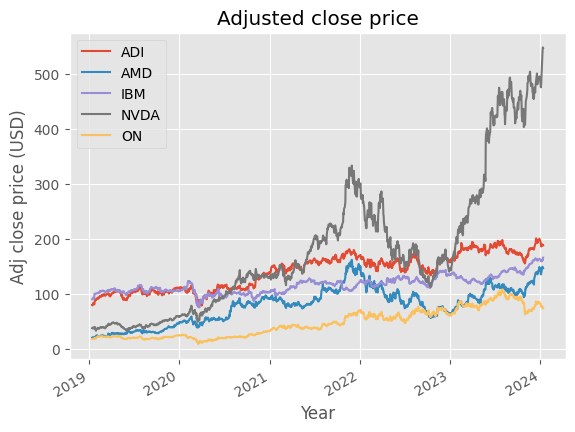

In [30]:
df['Adj Close'].plot(legend=True, title='Adjusted close price',xlabel='Year', ylabel='Adj close price (USD)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


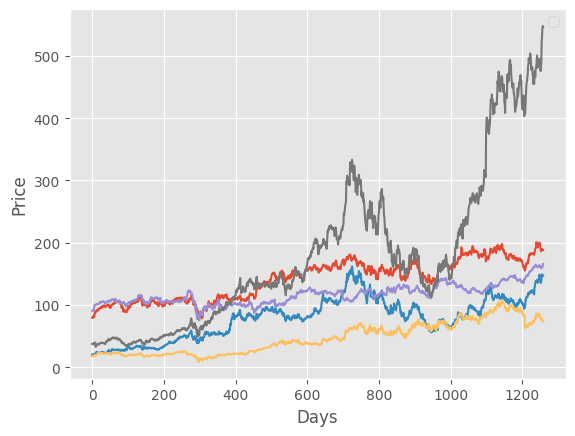

In [64]:
ema = df['Adj Close'].ewm(com=0.2).mean()
plt.plot(df['Adj Close'])
plt.xlabel("Year")
plt.ylabel("Adj closing price")
plt.legend()
plt.show()